In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

data_path = 'archive/'    # 원본 데이터 경로

In [2]:
# 이미지 경로 shuffle

import random

positive_file_path = data_path + 'positive_Covid-19/'    # 양성 데이터 경로
positive_file_list = os.listdir(positive_file_path)      # 양성 데이터들의 이름 리스트 (ex. ['positive_0_4642.jpg', 'positive_0_4284.jpg', ...]) 'positive_0_3582.jpg',)
random.shuffle(positive_file_list)                       # 리스트 요소들의 순서 shuffle

negative_file_path = data_path + 'negative_Covid-19/'
negative_file_list = os.listdir(negative_file_path)
random.shuffle(negative_file_list)

archive/negative_Covid-19/negative_0_826.jpg
archive/negative_Covid-19/negative_0_1507.jpg
archive/negative_Covid-19/negative_0_1889.jpg
archive/negative_Covid-19/negative_0_6631.jpg
archive/negative_Covid-19/negative_0_1344.jpg
archive/negative_Covid-19/negative_0_7572.jpg
archive/negative_Covid-19/negative_0_8994.jpg
archive/negative_Covid-19/negative_0_1449.jpg
archive/negative_Covid-19/negative_0_6709.jpg


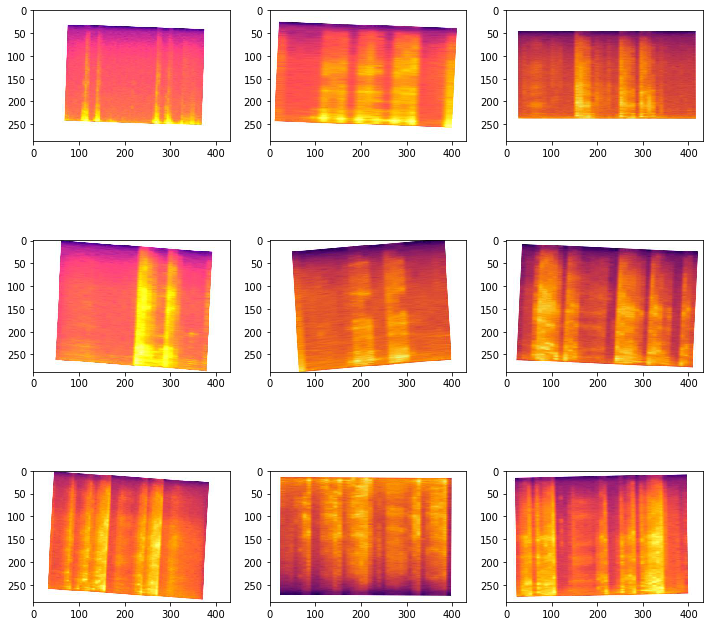

In [3]:
# 전처리 전 이미지 확인

plt.figure(figsize=(12, 12))    # plt.imshow 할 이미지 크기 적절히 조정
for i in range(3):
    for j in range(3):
        print(negative_file_path + negative_file_list[i * 3 + j])               # 데이터 경로와 이름을 조합하여 프린트
        img = cv2.imread(negative_file_path + negative_file_list[i * 3 + j])    # 이미지 읽어오기
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)                              # cv2와 plt간의 이미지 표현 방식 차이로 생기는 색 표현 문제를 X
        plt.subplot(330 + (i * 3 + j + 1))
        plt.imshow(img)

In [4]:
# 전처리 함수 (입력: 사진 경로, 출력: 전처리된 이미지)
def get_preprocessed_image(img_path):
    img = cv2.imread(img_path)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                       # 이진화 하기 위해 흑백사진으로 변경
    ret, thr = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)    # 밝기 200을 기준으로 이진화

    contours, hier = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)    # 이진화 된 데이터를 이용하여 윤곽 계산
    
    for c in contours:                              # 검출된 윤곽을 모두 순환
        if cv2.contourArea(c) > 0.2 * 432 * 288:    # 윤곽의 면적이 0.2 * 432 * 288 이상인것만 처리
            rect = cv2.minAreaRect(c)               # 윤곽을 포함하는 제일 작은 면적의 사각형 계산
            
            pts1 = cv2.boxPoints(rect)                                     # perspective transform을 하기 위해 사각형의 네 꼭지점 좌표 계산
            pts2 = np.float32([[0, 400], [0, 0], [400, 0], [400, 400]])    # 출력할 이미지의 네 꼭지점 좌표
            
            M = cv2.getPerspectiveTransform(pts1, pts2)
            dst = cv2.warpPerspective(img, M, (400,400))    # perspective transform하여 원본 데이터에서 유의미한 부분을 crop
            
            # crop한 이미지를 모두 같은 방향으로 정렬하기 위해 네 변의 픽셀의 합을 계산
            top = np.sum(dst[:50,:])    # 위쪽 변의 400*50만큼의 픽셀 합
            bottom = np.sum(dst[350:,:])
            left = np.sum(dst[:,:50])
            right = np.sum(dst[:,350:])
            
            # ex
            # top: 5296070
            # bottom: 7850642
            # left: 6777168    <- min
            # right: 7251397
            
            sum_min = min(left, right, top, bottom)    # 네 변중 가장 어두운 곳 계산
        
            if sum_min == top:
                dst = cv2.rotate(dst, cv2.ROTATE_180)                    # 180도 회전
            elif sum_min == bottom:
                pass
            elif sum_min == left:
                dst = cv2.rotate(dst, cv2.ROTATE_90_COUNTERCLOCKWISE)    # 반시계 90도 회전
            elif sum_min == right:
                dst = cv2.rotate(dst, cv2.ROTATE_90_CLOCKWISE)           # 시계 90도 회전

            return dst

In [5]:
# preprocessed_image 폴더 초기화

import shutil
import os

save_path = "preprocessed_data/"   # 전처리 한 데이터를 저장할 경로

# save_path 디렉토리가 이미 존재하면 삭제
if os.path.isdir(save_path):
    shutil.rmtree(save_path)

# 전처리 한 데이터를 저장할 디렉토리 생성
os.makedirs(save_path + "train/positive/")
os.makedirs(save_path + "train/negative/")
os.makedirs(save_path + "test/positive/")
os.makedirs(save_path + "test/negative/")

In [6]:
# 모든 이미지를 전처리하여 저장

for image_name in positive_file_list[:int(len(positive_file_list) * 0.8)]:    # positive 데이터의 80%를 train에 분류하여 저장
    img = get_preprocessed_image(positive_file_path + image_name)             # 전처리
    cv2.imwrite(save_path + "train/positive/" + image_name, img)              # 이미지 저장

# negative 데이터는 positive에 비해 데이터가 약 1/5배 이므로 양을 5배 늘려줌 (단순 복사)
# 데이터 양을 그대로 사용하거나 positive 데이터를 다운샘플링 했을때는 훈련 결과가 좋지 못하였음
for image_name in negative_file_list[:int(len(negative_file_list) * 0.8)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "train/negative/" + "A" + image_name, img)    
for image_name in negative_file_list[:int(len(negative_file_list) * 0.8)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "train/negative/" + "B" + image_name, img)    
for image_name in negative_file_list[:int(len(negative_file_list) * 0.8)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "train/negative/" + "C" + image_name, img)    
for image_name in negative_file_list[:int(len(negative_file_list) * 0.8)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "train/negative/" + "D" + image_name, img)    
for image_name in negative_file_list[:int(len(negative_file_list) * 0.8)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "train/negative/" + "E" + image_name, img)

# positive 데이터의 20%를 test로 분류하여 저장
for image_name in positive_file_list[:int(len(positive_file_list) * 0.2)]:
    img = get_preprocessed_image(positive_file_path + image_name)
    cv2.imwrite(save_path + "test/positive/" + image_name, img)
    
# negative 데이터의 20%를 test로 분류하여 저장
# 그리고 데이터 양을 5배로 늘림
for image_name in negative_file_list[:int(len(negative_file_list) * 0.2)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "test/negative/" + "A" + image_name, img)
for image_name in negative_file_list[:int(len(negative_file_list) * 0.2)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "test/negative/" + "B" + image_name, img)
for image_name in negative_file_list[:int(len(negative_file_list) * 0.2)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "test/negative/" + "C" + image_name, img)
for image_name in negative_file_list[:int(len(negative_file_list) * 0.2)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "test/negative/" + "D" + image_name, img)
for image_name in negative_file_list[:int(len(negative_file_list) * 0.2)]:
    img = get_preprocessed_image(negative_file_path + image_name)
    cv2.imwrite(save_path + "test/negative/" + "E" + image_name, img)

preprocessed_data/train/positive/positive_0_9174.jpg
preprocessed_data/train/positive/positive_0_3753.jpg
preprocessed_data/train/positive/positive_0_4741.jpg
preprocessed_data/train/positive/positive_0_1593.jpg
preprocessed_data/train/positive/positive_0_8408.jpg
preprocessed_data/train/positive/positive_0_8156.jpg
preprocessed_data/train/positive/positive_0_3322.jpg
preprocessed_data/train/positive/positive_0_8669.jpg
preprocessed_data/train/positive/positive_0_9511.jpg


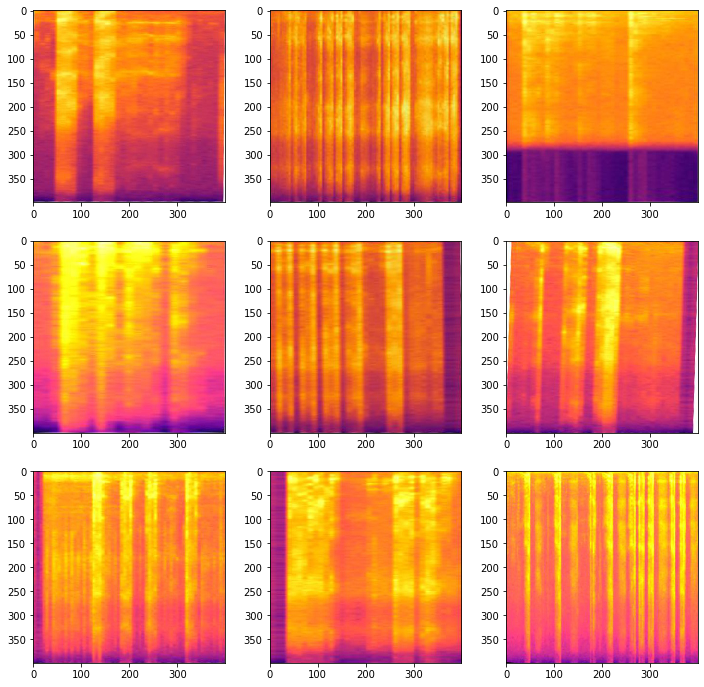

In [7]:
# 전처리, 저장된 파일들 확인

sample_file_path = save_path + "train/positive/"
sample_file_list = os.listdir(sample_file_path)

plt.figure(figsize=(12, 12))
for i in range(3):
    for j in range(3):
        print(sample_file_path + sample_file_list[i * 3 + j])
        img = cv2.imread(sample_file_path + sample_file_list[i * 3 + j])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(330 + (i * 3 + j + 1))
        plt.imshow(img)